In [ ]:
import os
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread,imsave
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import save_model, load_model, Model
from tensorflow.keras.layers import Input,InputLayer, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D
from sklearn.metrics import classification_report

In [ ]:
root='AFFINE_REG_SKS_MASK_2D_IMAGES_DIR/'

In [ ]:
def densenet201_row(optimizer, loss, metrics, shape):
    image_input = tf.keras.applications.DenseNet201(include_top=False, weights='imagenet', input_shape=shape)

    for layer in image_input.layers:
        layer.trainable = True
        layer._name = layer._name + str('_img')

    y = Flatten()(image_input.output)
    c = Dropout(0.4)(y)
    c = Dense(512)(c)
    c = Dense(256)(c)
    c = Dense(128)(c)
    output_layer = Dense(3, activation='softmax')(c)

    model = Model(inputs=image_input.input, outputs=output_layer)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [ ]:
def plot_confusion_matrix(true_lab,predict_lab,classes,path):
  matrix_confusion = tf.math.confusion_matrix(labels=true_lab, predictions=predicted_lab, num_classes=len(classes))
  ax = plt.subplot()
  sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.savefig(f'{path}confusion_matrix.png')


In [ ]:
def dump_text(text,path):
  text_file = open(path, "w")
  text_file.write(text)
  text_file.close()

In [ ]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

2024-03-25 10:46:58.494065: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 10:46:59.353967: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9629 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b2:00.0, compute capability: 7.5


In [ ]:
image_Shape=(436,364,3)
training_image_datagen = ImageDataGenerator(horizontal_flip=True).flow_from_directory(
                                                  directory=f'{root}/training/',
                                                  target_size=(image_Shape[0], image_Shape[1]),
                                                  class_mode='categorical',
                                                  batch_size=16
                                                  )

testing_image_datagen = ImageDataGenerator().flow_from_directory(
                                                  directory = f'{root}/testing/' ,
                                                  target_size = (image_Shape[0] ,image_Shape[1]) ,
                                                  class_mode = 'categorical' ,
                                                  batch_size=1 ,
                                                  shuffle = False
                                                  )

Found 11059 images belonging to 3 classes.
Found 494 images belonging to 3 classes.


In [ ]:
EPOCH = 50
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='Accuracy'),
    tf.keras.metrics.Precision(name='AD_Precision',class_id=0),
    tf.keras.metrics.Precision(name='CN_Precision',class_id=1),
    tf.keras.metrics.Precision(name='MCI_Precision',class_id=2),
    tf.keras.metrics.Recall(name='AD_Recall',class_id=0),
    tf.keras.metrics.Recall(name='CN_Recall',class_id=1),
    tf.keras.metrics.Recall(name='MCI_Recall',class_id=2),
    ]
LOOS = 'categorical_crossentropy'

2024-03-25 10:47:06.956055: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9629 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b2:00.0, compute capability: 7.5


In [ ]:
savepath = 'models'
lr=0.0001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'densenet201_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model05 = densenet201_row(OPT, LOOS,METRICS,image_Shape)
history05 = model05.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model05 = densenet201_row(OPT, LOOS,METRICS,image_Shape)
model05.load_weights(glob.glob(f"{savepath}densenet201_row_10E-5_weights-epoch:*-val_Accuracy:{max(history05.history['val_Accuracy']):.4f}.h5")[0])
model05.save(f"{savepath}/densenet201aug_50_0.0001.h5")

Epoch 1/50
1001/1106 [==========================>...] - ETA: 31s - loss: 1.0166 - Accuracy: 0.5154 - AD_Precision: 0.3779 - CN_Precision: 0.4879 - MCI_Precision: 0.5556 - AD_Recall: 0.0429 - CN_Recall: 0.2011 - MCI_Recall: 0.5798

2024-03-27 11:54:12.972354: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.68GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-03-27 11:54:13.105730: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


1106/1106 [==============================] - ETA: 0s - loss: 0.9981 - Accuracy: 0.5236 - AD_Precision: 0.4677 - CN_Precision: 0.5051 - MCI_Precision: 0.5638 - AD_Recall: 0.0715 - CN_Recall: 0.2189 - MCI_Recall: 0.5899

2024-03-27 11:54:48.719585: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


1106/1106 [==============================] - 370s 323ms/step - loss: 0.9981 - Accuracy: 0.5236 - AD_Precision: 0.4677 - CN_Precision: 0.5051 - MCI_Precision: 0.5638 - AD_Recall: 0.0715 - CN_Recall: 0.2189 - MCI_Recall: 0.5899 - val_loss: 1.3794 - val_Accuracy: 0.4028 - val_AD_Precision: 0.3089 - val_CN_Precision: 1.0000 - val_MCI_Precision: 0.5436 - val_AD_Recall: 0.7755 - val_CN_Recall: 0.0510 - val_MCI_Recall: 0.4435
Epoch 2/50
1106/1106 [==============================] - 356s 321ms/step - loss: 0.6647 - Accuracy: 0.7148 - AD_Precision: 0.7139 - CN_Precision: 0.7420 - MCI_Precision: 0.7452 - AD_Recall: 0.4741 - CN_Recall: 0.6735 - MCI_Recall: 0.7398 - val_loss: 0.8163 - val_Accuracy: 0.6619 - val_AD_Precision: 0.4244 - val_CN_Precision: 0.8393 - val_MCI_Precision: 0.7914 - val_AD_Recall: 0.7449 - val_CN_Recall: 0.5987 - val_MCI_Recall: 0.6192
Epoch 3/50
1106/1106 [==============================] - 358s 324ms/step - loss: 0.3844 - Accuracy: 0.8532 - AD_Precision: 0.8413 - CN_Precision

              precision    recall  f1-score   support

          AD       0.96      0.71      0.82        98
          CN       0.91      0.92      0.92       157
         MCI       0.87      0.95      0.91       239

    accuracy                           0.89       494
   macro avg       0.91      0.86      0.88       494
weighted avg       0.90      0.89      0.89       494



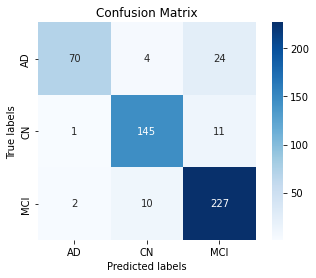

In [ ]:
p2 = model05.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save(f"{savepath}/densenet201aug_50_0.0001.npy",p2 )

In [ ]:
def resnet50_row(optimizer, loss,metrics,shape):
  image_input = tf.keras.applications.ResNet50(include_top=False,weights='imagenet',input_shape=shape)

  for layer in image_input.layers:
      layer.trainable = True
      layer._name = layer._name  + str('_img')

  y = Flatten() (image_input.output)
  c = Dropout(0.4) (y)
  c = Dense(512) (c)
  c = Dense(256) (c)
  c = Dense(128) (c)
  output_layer = Dense(3, activation='softmax')(c)

  model = Model(inputs=image_input.input,outputs=output_layer)
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  return model

In [ ]:
import subprocess
import time

def monitor_gpu_memory(interval=1):
    while True:
        result = subprocess.check_output(["nvidia-smi", "--query-gpu=memory.used,memory.free", "--format=csv"])
        print(result.decode("utf-8"))
        time.sleep(interval)

# Call the function to start monitoring
monitor_gpu_memory())


SyntaxError: unmatched ')' (556479921.py, line 11)

In [ ]:
# learning_rate=10E-5
savepath = 'models'
lr=0.0001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'resnet50_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model05 = resnet50_row(OPT, LOOS,METRICS,image_Shape)
history05 = model05.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model05 = resnet50_row(OPT, LOOS,METRICS,image_Shape)
model05.load_weights(glob.glob(f"{savepath}resnet50_row_10E-5_weights-epoch:*-val_Accuracy:{max(history05.history['val_Accuracy']):.4f}.h5")[0])

Epoch 1/50


2024-02-27 13:50:29.515015: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


1106/1106 [==============================] - 213s 185ms/step - loss: 3.5153 - Accuracy: 0.4603 - AD_Precision: 0.2905 - CN_Precision: 0.3935 - MCI_Precision: 0.5476 - AD_Recall: 0.1712 - CN_Recall: 0.3083 - MCI_Recall: 0.5524 - val_loss: 1.1435 - val_Accuracy: 0.5182 - val_AD_Precision: 0.5000 - val_CN_Precision: 0.6944 - val_MCI_Precision: 0.5081 - val_AD_Recall: 0.1020 - val_CN_Recall: 0.1592 - val_MCI_Recall: 0.9205
Epoch 2/50
1106/1106 [==============================] - 202s 183ms/step - loss: 0.9074 - Accuracy: 0.6098 - AD_Precision: 0.5446 - CN_Precision: 0.6209 - MCI_Precision: 0.6604 - AD_Recall: 0.3674 - CN_Recall: 0.5066 - MCI_Recall: 0.6718 - val_loss: 0.9136 - val_Accuracy: 0.6498 - val_AD_Precision: 0.4500 - val_CN_Precision: 0.7769 - val_MCI_Precision: 0.7131 - val_AD_Recall: 0.3673 - val_CN_Recall: 0.6433 - val_MCI_Recall: 0.7071
Epoch 3/50
1106/1106 [==============================] - 200s 181ms/step - loss: 0.6911 - Accuracy: 0.7183 - AD_Precision: 0.6811 - CN_Precision

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


              precision    recall  f1-score   support

          AD       0.93      0.76      0.83        98
          CN       0.92      0.84      0.88       157
         MCI       0.84      0.95      0.89       239

    accuracy                           0.88       494
   macro avg       0.90      0.85      0.87       494
weighted avg       0.88      0.88      0.88       494



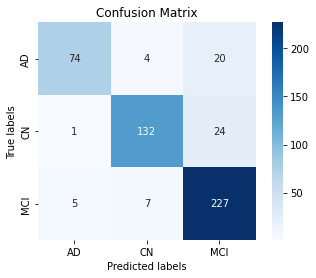

In [ ]:
model05.save(f"{savepath}/resnetaug_50_0.0001.h5")
p1 = model05.predict(testing_image_datagen)
predicted_lab = p1.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("resnetaug_50_0.0001.npy",p1 )

In [ ]:
def efficientnet_row(optimizer, loss, metrics, shape):
    image_input = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=shape)  # Change model to EfficientNet

    for layer in image_input.layers:
        layer.trainable = False
        layer._name = layer._name + str('_img')

    y = Flatten()(image_input.output)
    c = Dropout(0.4)(y)
    c = Dense(512)(c)
    c = Dense(256)(c)
    c = Dense(128)(c)
    output_layer = Dense(3, activation='softmax')(c)

    model = Model(inputs=image_input.input, outputs=output_layer)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

Epoch 1/50


2024-02-27 21:43:41.103430: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


1106/1106 [==============================] - 202s 147ms/step - loss: 1.8592 - Accuracy: 0.4926 - AD_Precision: 0.2529 - CN_Precision: 0.4063 - MCI_Precision: 0.5526 - AD_Recall: 0.0607 - CN_Recall: 0.1660 - MCI_Recall: 0.6010 - val_loss: 0.9679 - val_Accuracy: 0.5526 - val_AD_Precision: 0.5532 - val_CN_Precision: 0.9444 - val_MCI_Precision: 0.5860 - val_AD_Recall: 0.2653 - val_CN_Recall: 0.1083 - val_MCI_Recall: 0.6987
Epoch 2/50
1106/1106 [==============================] - 154s 139ms/step - loss: 0.8555 - Accuracy: 0.6048 - AD_Precision: 0.5833 - CN_Precision: 0.6494 - MCI_Precision: 0.6398 - AD_Recall: 0.2568 - CN_Recall: 0.4396 - MCI_Recall: 0.6736 - val_loss: 1.2116 - val_Accuracy: 0.5526 - val_AD_Precision: 0.6163 - val_CN_Precision: 1.0000 - val_MCI_Precision: 0.5445 - val_AD_Recall: 0.5408 - val_CN_Recall: 0.0573 - val_MCI_Recall: 0.8703
Epoch 3/50
1106/1106 [==============================] - 156s 141ms/step - loss: 0.5658 - Accuracy: 0.7644 - AD_Precision: 0.7490 - CN_Precision

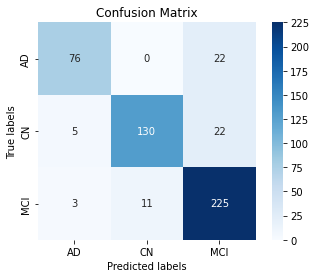

In [ ]:
savepath = 'models'
lr=0.00001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'efficientnet_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model02 = efficientnet_row(OPT, LOOS,METRICS,image_Shape)
history02 = model02.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model02 = efficientnet_row(OPT, LOOS,METRICS,image_Shape)
model02.load_weights(glob.glob(f"{savepath}efficientnet_row_10E-5_weights-epoch:*-val_Accuracy:{max(history02.history['val_Accuracy']):.4f}.h5")[0])
model02.save(f"{savepath}/efficientnetaug_50_0.0001.h5")
p2 = model02.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("efficientnetaug_50_0.0001.npy",p2 )

In [ ]:
import tensorflow as tf
image_Shape=(436,364,3)

def inceptionv3_row(optimizer, loss, metrics, shape):
    image_input = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=shape)

    for layer in image_input.layers:
        layer.trainable = True
        layer._name = layer._name + str('_img')

    x = Flatten()(image_input.output)
    x = Dropout(0.4)(x)
    x = Dense(512)(x)
    x = Dense(256)(x)
    x = Dense(128)(x)
    output_layer = Dense(3, activation='softmax')(x)

    model = Model(inputs=image_input.input, outputs=output_layer)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [ ]:
savepath = 'models'
lr=0.0001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'inceptionv3_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model03 = inceptionv3_row(OPT, LOOS,METRICS,image_Shape)
history03 = model03.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model03 = inceptionv3_row(OPT, LOOS,METRICS,image_Shape)
model03.load_weights(glob.glob(f"{savepath}inceptionv3_row_10E-5_weights-epoch:*-val_Accuracy:{max(history03.history['val_Accuracy']):.4f}.h5")[0])

Epoch 1/50


2024-03-05 17:45:50.775127: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2024-03-05 17:46:00.806606: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.73GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-03-05 17:46:00.815345: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.77GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-03-05 17:46:00.823943: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.81GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

 329/1106 [=======>......................] - ETA: 3:19 - loss: 3.7597 - Accuracy: 0.4410 - AD_Precision: 0.2599 - CN_Precision: 0.3646 - MCI_Precision: 0.5499 - AD_Recall: 0.2536 - CN_Recall: 0.3554 - MCI_Recall: 0.5495

2024-03-05 17:47:30.556135: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.65GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-03-05 17:47:30.579056: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


1106/1106 [==============================] - 338s 276ms/step - loss: 2.9646 - Accuracy: 0.4885 - AD_Precision: 0.3305 - CN_Precision: 0.4249 - MCI_Precision: 0.5820 - AD_Recall: 0.3137 - CN_Recall: 0.4124 - MCI_Recall: 0.5838 - val_loss: 2.5797 - val_Accuracy: 0.6336 - val_AD_Precision: 1.0000 - val_CN_Precision: 0.7063 - val_MCI_Precision: 0.6033 - val_AD_Recall: 0.0510 - val_CN_Recall: 0.5669 - val_MCI_Recall: 0.9163
Epoch 2/50
1106/1106 [==============================] - 306s 277ms/step - loss: 1.2456 - Accuracy: 0.6357 - AD_Precision: 0.5176 - CN_Precision: 0.6191 - MCI_Precision: 0.6974 - AD_Recall: 0.4760 - CN_Recall: 0.5869 - MCI_Recall: 0.7044 - val_loss: 0.9863 - val_Accuracy: 0.7146 - val_AD_Precision: 0.7955 - val_CN_Precision: 0.8362 - val_MCI_Precision: 0.6647 - val_AD_Recall: 0.3571 - val_CN_Recall: 0.6178 - val_MCI_Recall: 0.9205
Epoch 3/50
1106/1106 [==============================] - 305s 275ms/step - loss: 0.6653 - Accuracy: 0.7507 - AD_Precision: 0.7031 - CN_Precision

              precision    recall  f1-score   support

          AD       0.93      0.77      0.84        98
          CN       0.88      0.90      0.89       157
         MCI       0.87      0.92      0.89       239

    accuracy                           0.88       494
   macro avg       0.89      0.86      0.87       494
weighted avg       0.88      0.88      0.88       494



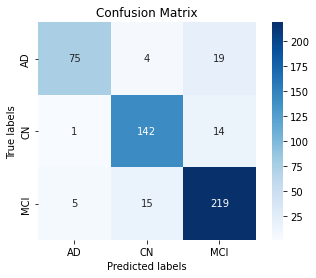

In [ ]:
model03.save(f"{savepath}/inceptionv3aug_50_0.00001.h5")
p3 = model03.predict(testing_image_datagen)
predicted_lab = p3.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("inceptionv3aug_50_0.00001.npy",p3 )

In [ ]:
def xception_row(optimizer, loss, metrics, shape):
    image_input = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape=shape)  # Change model to Xception

    for layer in image_input.layers:
        layer.trainable = False
        layer._name = layer._name + str('_img')

    y = Flatten()(image_input.output)
    c = Dropout(0.4)(y)
    c = Dense(512)(c)
    c = Dense(256)(c)
    c = Dense(128)(c)
    output_layer = Dense(3, activation='softmax')(c)

    model = Model(inputs=image_input.input, outputs=output_layer)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [ ]:
def plot_confusion_matrix(true_lab,predict_lab,classes,path):
  matrix_confusion = tf.math.confusion_matrix(labels=true_lab, predictions=predicted_lab, num_classes=len(classes))
  ax = plt.subplot()
  sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.savefig(f'{path}confusion_matrix.png')


In [ ]:
def dump_text(text,path):
  text_file = open(path, "w")
  text_file.write(text)
  text_file.close()

In [ ]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)


2024-03-23 18:44:25.198641: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9629 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:da:00.0, compute capability: 7.5


In [ ]:
image_Shape=(436,364,3)
training_image_datagen = ImageDataGenerator(horizontal_flip=True).flow_from_directory(
                                                  directory=f'{root}/training/',
                                                  target_size=(image_Shape[0], image_Shape[1]),
                                                  class_mode='categorical',
                                                  batch_size=4
                                                  )

testing_image_datagen = ImageDataGenerator().flow_from_directory(
                                                  directory = f'{root}/testing/' ,
                                                  target_size = (image_Shape[0] ,image_Shape[1]) ,
                                                  class_mode = 'categorical' ,
                                                  batch_size=1 ,
                                                  shuffle = False
                                                  )

Found 11059 images belonging to 3 classes.
Found 494 images belonging to 3 classes.


In [ ]:
EPOCH = 50
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='Accuracy'),
    tf.keras.metrics.Precision(name='AD_Precision',class_id=0),
    tf.keras.metrics.Precision(name='CN_Precision',class_id=1),
    tf.keras.metrics.Precision(name='MCI_Precision',class_id=2),
    tf.keras.metrics.Recall(name='AD_Recall',class_id=0),
    tf.keras.metrics.Recall(name='CN_Recall',class_id=1),
    tf.keras.metrics.Recall(name='MCI_Recall',class_id=2),
    ]
LOOS = 'categorical_crossentropy'

In [ ]:
savepath = 'models'
lr=0.000001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'xception_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.RMSprop(learning_rate=lr)
model05 = xception_row(OPT, LOOS,METRICS,image_Shape)
history05 = model05.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model05 = xception_row(OPT, LOOS,METRICS,image_Shape)
model05.load_weights(glob.glob(f"{savepath}xception_row_10E-5_weights-epoch:*-val_Accuracy:{max(history05.history['val_Accuracy']):.4f}.h5")[0])
model05.save(f"{savepath}/xceptionaug_50_0.000001.h5")
p2 = model05.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("xceptionaug_50_0.000001.npy",p2 )

Epoch 1/50


2024-03-25 10:47:33.983816: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


692/692 [==============================] - 242s 343ms/step - loss: 7.6349 - Accuracy: 0.4059 - AD_Precision: 0.2150 - CN_Precision: 0.3108 - MCI_Precision: 0.5275 - AD_Recall: 0.2150 - CN_Recall: 0.3027 - MCI_Recall: 0.5304 - val_loss: 4.2425 - val_Accuracy: 0.4676 - val_AD_Precision: 0.2034 - val_CN_Precision: 0.4786 - val_MCI_Precision: 0.5140 - val_AD_Recall: 0.1224 - val_CN_Recall: 0.4268 - val_MCI_Recall: 0.6151
Epoch 2/50
692/692 [==============================] - 85s 123ms/step - loss: 6.5513 - Accuracy: 0.4216 - AD_Precision: 0.2180 - CN_Precision: 0.3382 - MCI_Precision: 0.5423 - AD_Recall: 0.2168 - CN_Recall: 0.3333 - MCI_Recall: 0.5435 - val_loss: 5.4394 - val_Accuracy: 0.4838 - val_AD_Precision: 0.2222 - val_CN_Precision: 0.5000 - val_MCI_Precision: 0.4932 - val_AD_Recall: 0.0408 - val_CN_Recall: 0.1083 - val_MCI_Recall: 0.9121
Epoch 3/50
692/692 [==============================] - 85s 122ms/step - loss: 5.8963 - Accuracy: 0.4294 - AD_Precision: 0.2332 - CN_Precision: 0.3370

OSError: [Errno 28] Unable to create file (unable to open file: name = 'modelsxception_row_10E-5_weights-epoch:035-val_Accuracy:0.6235.h5', errno = 28, error message = 'No space left on device', flags = 13, o_flags = 242)

In [ ]:
model = tf.keras.models.load_model('/blue/oguzhan/swetha.lenkala/Finetuning_models/Xception/Adam/Xception_50_0.000001/xception_50_0.000001.h5')
predictions_densenet201 = model.predict(testing_image_datagen)

              precision    recall  f1-score   support

          AD       0.81      0.47      0.59        98
          CN       0.78      0.75      0.76       157
         MCI       0.74      0.88      0.80       239

    accuracy                           0.76       494
   macro avg       0.77      0.70      0.72       494
weighted avg       0.76      0.76      0.75       494



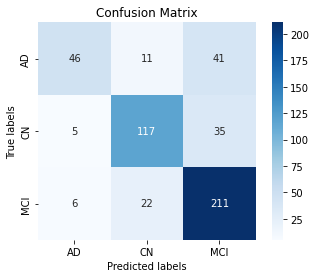

In [ ]:
savepath='models'
predicted_lab = predictions_densenet201.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)

np.save("resnet_100_0.0001.npy",predictions_densenet201 )

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
# Define directories
base_dir = 'AFFINE_REG_SKS_MASK_2D_IMAGES_DIR'
train_dir = os.path.join(base_dir, 'training')
augmented_dir = os.path.join(base_dir, 'augmented')

# Define subdirectories
classes = ['MCI', 'AD', 'CN']

# Data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    fill_mode='nearest'
)

def augment_images(input_dir, output_dir, class_name):
    class_dir = os.path.join(input_dir, class_name)
    output_class_dir = os.path.join(output_dir, class_name)
    if not os.path.exists(output_class_dir):
        os.makedirs(output_class_dir)

    # List only files (not directories) in the class directory
    images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f)) and not f.startswith('.')]
    for img_name in images:
        img_path = os.path.join(class_dir, img_name)
        img = np.array(Image.open(img_path))  # Load image using PIL
        img = np.expand_dims(img, axis=-1)  # Add channel dimension (assuming images are grayscale)
        img = np.expand_dims(img, axis=0)   # Add batch dimension
        # Generate augmented images
        for i, batch in enumerate(datagen.flow(img, batch_size=1, save_to_dir=output_class_dir, save_prefix='aug_', save_format='png')):
            if i >= 5:  # Number of augmented images to generate
                break



# Augment images for each class
for class_name in classes:
    augment_images(train_dir, augmented_dir, class_name)


In [ ]:
import os

# Define base directory
base_dir = 'AFFINE_REG_SKS_MASK_2D_IMAGES_DIR'
train_dir = os.path.join(base_dir, 'AD')

# Define subdirectories
#classes = ['MCI', 'AD', 'CN']

# Function to count images in a directory
def count_images(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png') or file.endswith('.jpeg'):
                count += 1
    return count

# Count images for each clas

    num_images = count_images(class_dir)
    print(f"Number of images in : {num_images}")


In [ ]:
import os
import shutil

# Define directories
base_dir = 'AFFINE_REG_SKS_MASK_2D_IMAGES_DIR'
augmented_dir = os.path.join(base_dir, 'augmented')

# Define subdirectories
classes = ['MCI', 'AD', 'CN']

# Iterate over each class directory
for class_name in classes:
    class_dir = os.path.join(augmented_dir, class_name)
    output_class_dir = os.path.join(base_dir, class_name)

    # Ensure the output directory exists
    if not os.path.exists(output_class_dir):
        os.makedirs(output_class_dir)

    # Iterate over images in the class directory
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)

        # Skip hidden directories
        if os.path.isdir(img_path):
            continue

        # Copy original images to the output directory
        if not img_name.startswith('aug_'):
            shutil.copy(img_path, output_class_dir)

        # Copy augmented images to the output directory
        else:
            augmented_img_path = os.path.join(class_dir, img_name)
            shutil.copy(augmented_img_path, output_class_dir)


In [ ]:
import os
import shutil

# Define directories
base_dir = 'AFFINE_REG_SKS_MASK_2D_IMAGES_DIR'
original_dir = os.path.join(base_dir, 'training')
augmented_dir = os.path.join(base_dir, 'augmented')

# Define subdirectories
classes = ['MCI', 'AD', 'CN']

# Function to copy images from augmented directory to original directory
def combine_images(original_dir, augmented_dir, class_name):
    original_class_dir = os.path.join(original_dir, class_name)
    augmented_class_dir = os.path.join(augmented_dir, class_name)

    # Ensure the output directory exists
    if not os.path.exists(original_class_dir):
        os.makedirs(original_class_dir)

    # Copy augmented images to the original directory
    for img_name in os.listdir(augmented_class_dir):
        if img_name.startswith('.') or img_name.endswith('.ipynb_checkpoints'):
            continue  # Skip hidden directories and checkpoints
        img_path = os.path.join(augmented_class_dir, img_name)
        shutil.copy(img_path, original_class_dir)

# Combine images for each class
for class_name in classes:
    combine_images(original_dir, augmented_dir, class_name)
